In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# raw_dataset = pd.read_csv("/data/fast0/datasets/glathida-3.1.0/data/T.csv")
# raw_dataset = pd.read_csv("~/notebooks/glac/data/TTT.csv")
raw_dataset = pd.read_csv("~/stuff/coding/glacier/glac/data/T.csv")

dataset = raw_dataset.copy()

#examine missing data
# dataset.head()

2.6.0


In [2]:
#drop everything but lat, long, elevation, thickness

dataset = dataset.drop("GlaThiDa_ID", axis=1)
dataset = dataset.drop("GLACIER_DB", axis=1)
dataset = dataset.drop("POLITICAL_UNIT", axis=1)
dataset = dataset.drop("GLACIER_ID", axis=1)
dataset = dataset.drop("GLACIER_NAME", axis=1)
dataset = dataset.drop("SURVEY_DATE", axis=1)
dataset = dataset.drop("MEAN_THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("MAXIMUM_THICKNESS", axis=1)
dataset = dataset.drop("MAX_THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("DATA_FLAG", axis=1)
dataset = dataset.drop("ELEVATION_DATE", axis=1)
dataset = dataset.drop("SPONSORING_AGENCY", axis=1)
dataset = dataset.drop("REMARKS", axis=1)
dataset = dataset.drop("SURVEY_METHOD_DETAILS", axis=1)
dataset = dataset.drop("SURVEY_METHOD", axis=1)
dataset = dataset.drop("NUMBER_OF_SURVEY_POINTS", axis=1)
dataset = dataset.drop("NUMBER_OF_SURVEY_PROFILES", axis=1)
dataset = dataset.drop("TOTAL_LENGTH_OF_SURVEY_PROFILES", axis=1)
dataset = dataset.drop("INTERPOLATION_METHOD", axis=1)
dataset = dataset.drop("INVESTIGATOR", axis=1)
dataset = dataset.drop("REFERENCES", axis=1)

#sum up rows with empty cells
dataset.isna().sum()

#drop the remaining null pieces from elevation
dataset = dataset.dropna()
dataset.isna().sum()

LAT               0
LON               0
AREA              0
MEAN_SLOPE        0
MEAN_THICKNESS    0
dtype: int64

In [3]:
dataset

,LAT,LON,AREA,MEAN_SLOPE,MEAN_THICKNESS
32,48.750000,-121.830000,2.900,0.0,58.0
33,58.380000,-134.360000,11.700,0.0,66.0
34,50.061340,87.697410,5.150,0.0,56.0
35,50.049670,87.745520,2.840,0.0,86.0
36,50.080080,87.690250,5.950,0.0,90.0
...,...,...,...,...,...
620,78.245480,16.064380,2.100,13.0,32.0
628,43.043653,77.080587,2.610,20.0,47.0
632,77.971400,14.069100,6.737,6.0,65.0
749,77.027200,15.485400,0.370,19.0,27.0


# 

In [4]:
#split the dataset and reserve some to test what was trained.
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

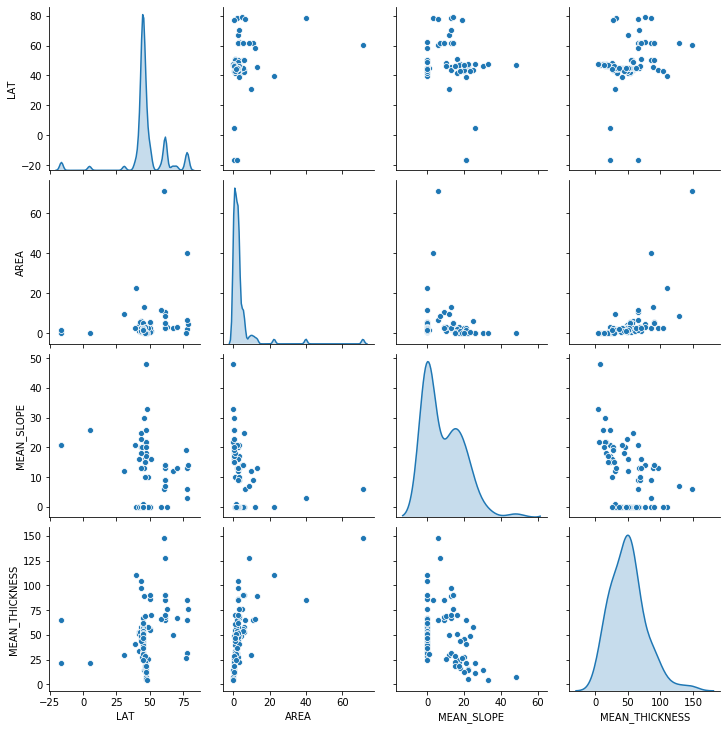

In [5]:
sns.pairplot(train_dataset[["LAT", "AREA", "MEAN_SLOPE", "MEAN_THICKNESS"]], diag_kind='kde')

In [6]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LAT,89.0,47.465341,14.458029,-16.3023,44.584600,45.080000,48.75000,78.87100
LON,89.0,41.704321,55.546192,-134.3600,8.602228,78.176022,79.82588,140.86536
AREA,89.0,4.060882,8.853776,0.0264,1.000000,2.100000,3.22750,71.30000
MEAN_SLOPE,89.0,8.797753,10.230502,0.0000,0.000000,6.000000,16.00000,48.00000
MEAN_THICKNESS,89.0,50.460674,27.011806,4.0000,30.000000,49.000000,65.00000,148.00000


In [7]:
#separate out features - what will be trained to predict desired attribute
train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop("MEAN_THICKNESS")
test_labels = test_features.pop("MEAN_THICKNESS")

train_features.describe().transpose()[['mean', 'std']]

,mean,std
LAT,47.465341,14.458029
LON,41.704321,55.546192
AREA,4.060882,8.853776
MEAN_SLOPE,8.797753,10.230502


# Establish normalization layers

In [8]:
#build normalizer layers for each model to be run

normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

area = np.array(train_features["AREA"])
area_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
area_normalizer.adapt(area)

lat = np.array(train_features["LAT"])
lat_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
lat_normalizer.adapt(lat)

lon = np.array(train_features["LON"])
lon_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
lon_normalizer.adapt(lon)

slope = np.array(train_features["MEAN_SLOPE"])
slope_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
slope_normalizer.adapt(slope)

# build model function to call

In [9]:
# #how to condense model into callable function with fillable variables? even possible?
# 88_model = tf.keras.Sequential([
#     88_normalizer,
#     layers.Dense(1)
# ])


# 88_model.compile(
#     optimizer=tf.optimizers.Adam(learning_rate=0.1),
#     loss="mean_absolute_error")

# %%time
# history_88 = 88_model.fit(
#     train_features["*^*"], train_labels,
#     epochs=400,
#     # suppress logging
#     verbose=0,
#     # Calculate validation results on 20% of the training data
#     validation_split = 0.2)

# test_results = {}
# test_results["*_model"] = area_model.evaluate(
#     test_features["*^*"],
#     test_labels, verbose=0)

# test_results

# def plot_area(x, y):
#     plt.scatter(train_features["*^*"], train_labels, label='Data')
#     plt.plot(x, y, color='k', label='Predictions')
#     plt.xlabel('Area (km**2)')
#     plt.ylabel('Thickness')
#     plt.xlim((0,20))
#     plt.legend()
    
# x = tf.linspace(0.0, 20, 101)
# y = area_model.predict(x)
# plot_area(x,y)

# def plot_loss(history_area):
#   plt.plot(history_area.history['loss'], label='loss')
#   plt.plot(history_area.history['val_loss'], label='val_loss')
# #   plt.ylim([0, 10])
#   plt.xlabel('Epoch')
#   plt.ylabel('Error [MPG]')
#   plt.legend()
#   plt.grid(True)
# plot_loss(history_area)



# Linear regression with area

In [10]:
#build elevation model with Sequential
area_model = tf.keras.Sequential([
    area_normalizer,
    layers.Dense(1)
])

area_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.6),
    loss="mean_absolute_error")

history_area = area_model.fit(
    train_features["AREA"], train_labels,
    epochs=1000,
    verbose=0,
    validation_split = 0.2)

test_results = {}
test_results['area_model'] = area_model.evaluate(
    test_features['AREA'],
    test_labels, verbose=0)

test_results

{'area_model': 75.56726837158203}

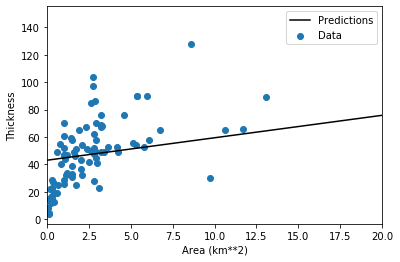

In [11]:
def plot_area(x, y):
    plt.scatter(train_features['AREA'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Area (km**2)')
    plt.ylabel('Thickness')
    plt.xlim((0,20))
    plt.legend()
    
x = tf.linspace(0.0, 20, 101)
y = area_model.predict(x)
plot_area(x,y)

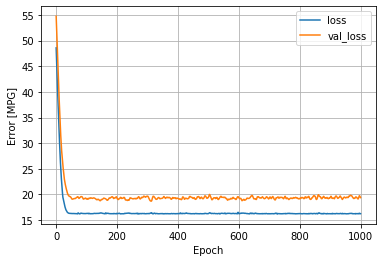

In [12]:
def plot_loss(history_area):
  plt.plot(history_area.history['loss'], label='loss')
  plt.plot(history_area.history['val_loss'], label='val_loss')
#   plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history_area)


# Linear regression with latitude

In [13]:
#build elevation model with Sequential
lat_model = tf.keras.Sequential([
    lat_normalizer,
    layers.Dense(1)
])

lat_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss="mean_absolute_error")

history_lat = lat_model.fit(
    train_features["LAT"], train_labels,
    epochs=400,
    verbose=0,
    validation_split = 0.2)

test_results["lat_model"] = area_model.evaluate(
    test_features["LAT"],
    test_labels, verbose=0)

test_results

{'area_model': 75.56726837158203, 'lat_model': 82.7318115234375}

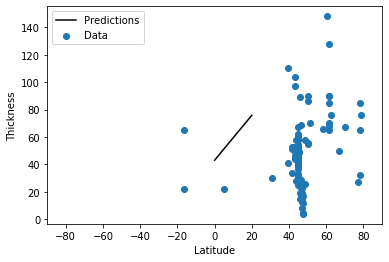

In [14]:
def plot_latitude(x, y):
    plt.scatter(train_features["LAT"], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel("Latitude")
    plt.ylabel('Thickness')
    plt.xlim((-90,90))
    plt.legend()
    
x = tf.linspace(0.0, 20, 101)
y = area_model.predict(x)
plot_latitude(x,y)

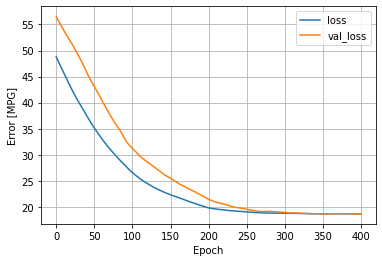

In [15]:
plot_loss(history_lat)

# Linear regression with longitude

In [16]:
lon_model = tf.keras.Sequential([
    lon_normalizer,
    layers.Dense(1)
])

lon_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss="mean_absolute_error")

history_lon = lon_model.fit(
    train_features["LON"], train_labels,
    epochs=400,
    verbose=0,
    validation_split = 0.2)

test_results["lon_model"] = area_model.evaluate(
    test_features["LON"],
    test_labels, verbose=0)

test_results

{'area_model': 75.56726837158203,
 'lat_model': 82.7318115234375,
 'lon_model': 93.16325378417969}

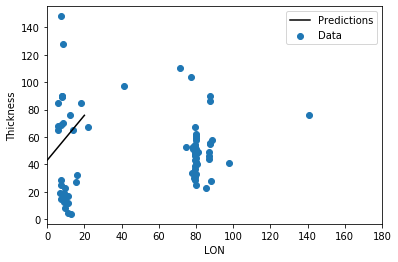

In [17]:
def plot_longitude(x, y):
    plt.scatter(train_features["LON"], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('LON')
    plt.ylabel('Thickness')
    plt.xlim((0,180))
    plt.legend()
    
x = tf.linspace(0.0, 20, 101)
y = area_model.predict(x)
plot_longitude(x,y)

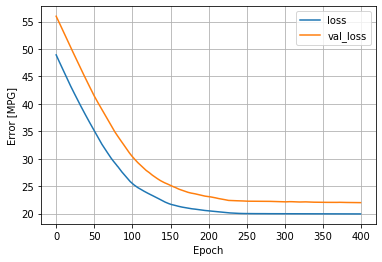

In [18]:
plot_loss(history_lon)

# Multiple inputs

In [19]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
multi_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [20]:
multi_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss='mean_absolute_error')

In [21]:
%%time
history_multi = multi_model.fit(
    train_features, train_labels, 
    epochs=1000,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 14.2 s, sys: 717 ms, total: 14.9 s
Wall time: 12.9 s


In [22]:
#not sure what exactly is going on here but I'm sure this is what needs tweaking
test_results["multi_model"] = multi_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results

{'area_model': 75.56726837158203,
 'lat_model': 82.7318115234375,
 'lon_model': 93.16325378417969,
 'multi_model': 44.313289642333984}

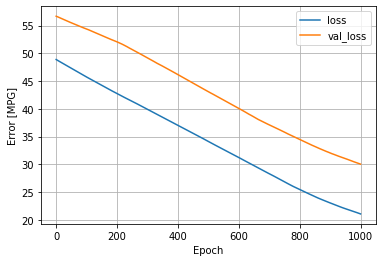

In [23]:
plot_loss(history_multi)

# DNN regression

### Single variable

In [24]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.0001))
  return model

In [25]:
dnn_area_model = build_and_compile_model(area_normalizer)

In [26]:
dnn_area_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [27]:
%%time
history_dnn = dnn_area_model.fit(
    train_features["AREA"], train_labels,
    validation_split=0.2,
    #verbose=0,
    epochs=1500)

Epoch 1/1500
3/3 [==============================] - 0s 102ms/step - loss: 48.9584 - val_loss: 56.5181
Epoch 2/1500
3/3 [==============================] - 0s 11ms/step - loss: 48.9524 - val_loss: 56.5138
Epoch 3/1500
3/3 [==============================] - 0s 14ms/step - loss: 48.9462 - val_loss: 56.5094
Epoch 4/1500
3/3 [==============================] - 0s 12ms/step - loss: 48.9403 - val_loss: 56.5051
Epoch 5/1500
3/3 [==============================] - 0s 9ms/step - loss: 48.9343 - val_loss: 56.5008
Epoch 6/1500
3/3 [==============================] - 0s 13ms/step - loss: 48.9286 - val_loss: 56.4966
Epoch 7/1500
3/3 [==============================] - 0s 8ms/step - loss: 48.9231 - val_loss: 56.4925
Epoch 8/1500
3/3 [==============================] - 0s 12ms/step - loss: 48.9170 - val_loss: 56.4885
Epoch 9/1500
3/3 [==============================] - 0s 9ms/step - loss: 48.9114 - val_loss: 56.4846
Epoch 10/1500
3/3 [==============================] - 0s 14ms/step - loss: 48.9057 - val_loss:

3/3 [==============================] - 0s 21ms/step - loss: 48.3702 - val_loss: 56.0841
Epoch 82/1500
3/3 [==============================] - 0s 9ms/step - loss: 48.3586 - val_loss: 56.0753
Epoch 83/1500
3/3 [==============================] - 0s 12ms/step - loss: 48.3472 - val_loss: 56.0664
Epoch 84/1500
3/3 [==============================] - 0s 9ms/step - loss: 48.3360 - val_loss: 56.0573
Epoch 85/1500
3/3 [==============================] - 0s 11ms/step - loss: 48.3246 - val_loss: 56.0482
Epoch 86/1500
3/3 [==============================] - 0s 12ms/step - loss: 48.3128 - val_loss: 56.0391
Epoch 87/1500
3/3 [==============================] - 0s 11ms/step - loss: 48.3013 - val_loss: 56.0297
Epoch 88/1500
3/3 [==============================] - 0s 12ms/step - loss: 48.2895 - val_loss: 56.0203
Epoch 89/1500
3/3 [==============================] - 0s 10ms/step - loss: 48.2773 - val_loss: 56.0106
Epoch 90/1500
3/3 [==============================] - 0s 12ms/step - loss: 48.2650 - val_loss: 56.0

Epoch 161/1500
3/3 [==============================] - 0s 11ms/step - loss: 46.8326 - val_loss: 54.7811
Epoch 162/1500
3/3 [==============================] - 0s 11ms/step - loss: 46.8020 - val_loss: 54.7545
Epoch 163/1500
3/3 [==============================] - 0s 11ms/step - loss: 46.7718 - val_loss: 54.7277
Epoch 164/1500
3/3 [==============================] - 0s 11ms/step - loss: 46.7410 - val_loss: 54.7006
Epoch 165/1500
3/3 [==============================] - 0s 10ms/step - loss: 46.7107 - val_loss: 54.6730
Epoch 166/1500
3/3 [==============================] - 0s 11ms/step - loss: 46.6787 - val_loss: 54.6452
Epoch 167/1500
3/3 [==============================] - 0s 10ms/step - loss: 46.6470 - val_loss: 54.6170
Epoch 168/1500
3/3 [==============================] - 0s 10ms/step - loss: 46.6151 - val_loss: 54.5885
Epoch 169/1500
3/3 [==============================] - 0s 11ms/step - loss: 46.5829 - val_loss: 54.5597
Epoch 170/1500
3/3 [==============================] - 0s 10ms/step - loss

3/3 [==============================] - 0s 11ms/step - loss: 43.3404 - val_loss: 51.6165
Epoch 241/1500
3/3 [==============================] - 0s 11ms/step - loss: 43.2855 - val_loss: 51.5625
Epoch 242/1500
3/3 [==============================] - 0s 12ms/step - loss: 43.2309 - val_loss: 51.5081
Epoch 243/1500
3/3 [==============================] - 0s 11ms/step - loss: 43.1722 - val_loss: 51.4538
Epoch 244/1500
3/3 [==============================] - 0s 10ms/step - loss: 43.1159 - val_loss: 51.3988
Epoch 245/1500
3/3 [==============================] - 0s 12ms/step - loss: 43.0599 - val_loss: 51.3436
Epoch 246/1500
3/3 [==============================] - 0s 10ms/step - loss: 43.0024 - val_loss: 51.2888
Epoch 247/1500
3/3 [==============================] - 0s 11ms/step - loss: 42.9439 - val_loss: 51.2330
Epoch 248/1500
3/3 [==============================] - 0s 11ms/step - loss: 42.8860 - val_loss: 51.1762
Epoch 249/1500
3/3 [==============================] - 0s 11ms/step - loss: 42.8253 - val

3/3 [==============================] - 0s 13ms/step - loss: 37.7118 - val_loss: 46.0913
Epoch 320/1500
3/3 [==============================] - 0s 13ms/step - loss: 37.6271 - val_loss: 46.0056
Epoch 321/1500
3/3 [==============================] - 0s 10ms/step - loss: 37.5398 - val_loss: 45.9205
Epoch 322/1500
3/3 [==============================] - 0s 12ms/step - loss: 37.4525 - val_loss: 45.8349
Epoch 323/1500
3/3 [==============================] - 0s 10ms/step - loss: 37.3683 - val_loss: 45.7472
Epoch 324/1500
3/3 [==============================] - 0s 11ms/step - loss: 37.2799 - val_loss: 45.6580
Epoch 325/1500
3/3 [==============================] - 0s 10ms/step - loss: 37.1934 - val_loss: 45.5683
Epoch 326/1500
3/3 [==============================] - 0s 11ms/step - loss: 37.1055 - val_loss: 45.4796
Epoch 327/1500
3/3 [==============================] - 0s 10ms/step - loss: 37.0176 - val_loss: 45.3907
Epoch 328/1500
3/3 [==============================] - 0s 10ms/step - loss: 36.9297 - val

3/3 [==============================] - 0s 13ms/step - loss: 30.3611 - val_loss: 38.8086
Epoch 399/1500
3/3 [==============================] - 0s 11ms/step - loss: 30.2590 - val_loss: 38.7034
Epoch 400/1500
3/3 [==============================] - 0s 12ms/step - loss: 30.1521 - val_loss: 38.5984
Epoch 401/1500
3/3 [==============================] - 0s 10ms/step - loss: 30.0504 - val_loss: 38.4945
Epoch 402/1500
3/3 [==============================] - 0s 11ms/step - loss: 29.9610 - val_loss: 38.3906
Epoch 403/1500
3/3 [==============================] - 0s 13ms/step - loss: 29.8592 - val_loss: 38.2894
Epoch 404/1500
3/3 [==============================] - 0s 10ms/step - loss: 29.7720 - val_loss: 38.1881
Epoch 405/1500
3/3 [==============================] - 0s 12ms/step - loss: 29.6778 - val_loss: 38.0899
Epoch 406/1500
3/3 [==============================] - 0s 10ms/step - loss: 29.5856 - val_loss: 37.9932
Epoch 407/1500
3/3 [==============================] - 0s 12ms/step - loss: 29.4931 - val

3/3 [==============================] - 0s 11ms/step - loss: 23.5482 - val_loss: 31.2390
Epoch 478/1500
3/3 [==============================] - 0s 10ms/step - loss: 23.4735 - val_loss: 31.1625
Epoch 479/1500
3/3 [==============================] - 0s 11ms/step - loss: 23.3960 - val_loss: 31.0877
Epoch 480/1500
3/3 [==============================] - 0s 10ms/step - loss: 23.3278 - val_loss: 31.0116
Epoch 481/1500
3/3 [==============================] - 0s 9ms/step - loss: 23.2427 - val_loss: 30.9440
Epoch 482/1500
3/3 [==============================] - 0s 20ms/step - loss: 23.1939 - val_loss: 30.8759
Epoch 483/1500
3/3 [==============================] - 0s 9ms/step - loss: 23.1289 - val_loss: 30.8135
Epoch 484/1500
3/3 [==============================] - 0s 11ms/step - loss: 23.0740 - val_loss: 30.7514
Epoch 485/1500
3/3 [==============================] - 0s 11ms/step - loss: 23.0208 - val_loss: 30.6900
Epoch 486/1500
3/3 [==============================] - 0s 12ms/step - loss: 22.9655 - val_l

3/3 [==============================] - 0s 24ms/step - loss: 20.9496 - val_loss: 27.5431
Epoch 557/1500
3/3 [==============================] - 0s 9ms/step - loss: 20.9250 - val_loss: 27.5003
Epoch 558/1500
3/3 [==============================] - 0s 12ms/step - loss: 20.9105 - val_loss: 27.4552
Epoch 559/1500
3/3 [==============================] - 0s 10ms/step - loss: 20.8832 - val_loss: 27.4147
Epoch 560/1500
3/3 [==============================] - 0s 10ms/step - loss: 20.8645 - val_loss: 27.3702
Epoch 561/1500
3/3 [==============================] - 0s 10ms/step - loss: 20.8453 - val_loss: 27.3283
Epoch 562/1500
3/3 [==============================] - 0s 9ms/step - loss: 20.8267 - val_loss: 27.2865
Epoch 563/1500
3/3 [==============================] - 0s 12ms/step - loss: 20.8115 - val_loss: 27.2448
Epoch 564/1500
3/3 [==============================] - 0s 9ms/step - loss: 20.7914 - val_loss: 27.2053
Epoch 565/1500
3/3 [==============================] - 0s 11ms/step - loss: 20.7788 - val_lo

3/3 [==============================] - 0s 10ms/step - loss: 19.6119 - val_loss: 24.8300
Epoch 636/1500
3/3 [==============================] - 0s 12ms/step - loss: 19.5948 - val_loss: 24.7978
Epoch 637/1500
3/3 [==============================] - 0s 10ms/step - loss: 19.5781 - val_loss: 24.7605
Epoch 638/1500
3/3 [==============================] - 0s 12ms/step - loss: 19.5565 - val_loss: 24.7263
Epoch 639/1500
3/3 [==============================] - 0s 10ms/step - loss: 19.5411 - val_loss: 24.6948
Epoch 640/1500
3/3 [==============================] - 0s 11ms/step - loss: 19.5249 - val_loss: 24.6634
Epoch 641/1500
3/3 [==============================] - 0s 11ms/step - loss: 19.5083 - val_loss: 24.6340
Epoch 642/1500
3/3 [==============================] - 0s 11ms/step - loss: 19.4922 - val_loss: 24.6037
Epoch 643/1500
3/3 [==============================] - 0s 9ms/step - loss: 19.4812 - val_loss: 24.5741
Epoch 644/1500
3/3 [==============================] - 0s 10ms/step - loss: 19.4640 - val_

3/3 [==============================] - 0s 11ms/step - loss: 18.7240 - val_loss: 22.8799
Epoch 715/1500
3/3 [==============================] - 0s 11ms/step - loss: 18.7158 - val_loss: 22.8493
Epoch 716/1500
3/3 [==============================] - 0s 9ms/step - loss: 18.7050 - val_loss: 22.8177
Epoch 717/1500
3/3 [==============================] - 0s 11ms/step - loss: 18.6948 - val_loss: 22.7874
Epoch 718/1500
3/3 [==============================] - 0s 10ms/step - loss: 18.6868 - val_loss: 22.7606
Epoch 719/1500
3/3 [==============================] - 0s 13ms/step - loss: 18.6798 - val_loss: 22.7306
Epoch 720/1500
3/3 [==============================] - 0s 10ms/step - loss: 18.6756 - val_loss: 22.7011
Epoch 721/1500
3/3 [==============================] - 0s 11ms/step - loss: 18.6633 - val_loss: 22.6816
Epoch 722/1500
3/3 [==============================] - 0s 12ms/step - loss: 18.6562 - val_loss: 22.6593
Epoch 723/1500
3/3 [==============================] - 0s 12ms/step - loss: 18.6478 - val_

3/3 [==============================] - 0s 12ms/step - loss: 18.2368 - val_loss: 21.6516
Epoch 794/1500
3/3 [==============================] - 0s 12ms/step - loss: 18.2343 - val_loss: 21.6406
Epoch 795/1500
3/3 [==============================] - 0s 10ms/step - loss: 18.2272 - val_loss: 21.6327
Epoch 796/1500
3/3 [==============================] - 0s 12ms/step - loss: 18.2235 - val_loss: 21.6178
Epoch 797/1500
3/3 [==============================] - 0s 10ms/step - loss: 18.2165 - val_loss: 21.6035
Epoch 798/1500
3/3 [==============================] - 0s 12ms/step - loss: 18.2104 - val_loss: 21.5903
Epoch 799/1500
3/3 [==============================] - 0s 10ms/step - loss: 18.2067 - val_loss: 21.5785
Epoch 800/1500
3/3 [==============================] - 0s 12ms/step - loss: 18.2002 - val_loss: 21.5694
Epoch 801/1500
3/3 [==============================] - 0s 10ms/step - loss: 18.1954 - val_loss: 21.5571
Epoch 802/1500
3/3 [==============================] - 0s 10ms/step - loss: 18.1903 - val

3/3 [==============================] - 0s 13ms/step - loss: 17.8823 - val_loss: 20.8683
Epoch 873/1500
3/3 [==============================] - 0s 12ms/step - loss: 17.8796 - val_loss: 20.8696
Epoch 874/1500
3/3 [==============================] - 0s 10ms/step - loss: 17.8754 - val_loss: 20.8713
Epoch 875/1500
3/3 [==============================] - 0s 13ms/step - loss: 17.8747 - val_loss: 20.8714
Epoch 876/1500
3/3 [==============================] - 0s 10ms/step - loss: 17.8697 - val_loss: 20.8627
Epoch 877/1500
3/3 [==============================] - 0s 10ms/step - loss: 17.8657 - val_loss: 20.8551
Epoch 878/1500
3/3 [==============================] - 0s 10ms/step - loss: 17.8617 - val_loss: 20.8418
Epoch 879/1500
3/3 [==============================] - 0s 13ms/step - loss: 17.8571 - val_loss: 20.8319
Epoch 880/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.8529 - val_loss: 20.8218
Epoch 881/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.8491 - val

3/3 [==============================] - 0s 12ms/step - loss: 17.5995 - val_loss: 20.2543
Epoch 952/1500
3/3 [==============================] - 0s 12ms/step - loss: 17.5972 - val_loss: 20.2509
Epoch 953/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.5930 - val_loss: 20.2495
Epoch 954/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.5894 - val_loss: 20.2512
Epoch 955/1500
3/3 [==============================] - 0s 10ms/step - loss: 17.5866 - val_loss: 20.2523
Epoch 956/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.5826 - val_loss: 20.2520
Epoch 957/1500
3/3 [==============================] - 0s 10ms/step - loss: 17.5812 - val_loss: 20.2541
Epoch 958/1500
3/3 [==============================] - 0s 9ms/step - loss: 17.5768 - val_loss: 20.2509
Epoch 959/1500
3/3 [==============================] - 0s 10ms/step - loss: 17.5744 - val_loss: 20.2527
Epoch 960/1500
3/3 [==============================] - 0s 10ms/step - loss: 17.5697 - val_

3/3 [==============================] - 0s 12ms/step - loss: 17.3592 - val_loss: 20.1075
Epoch 1031/1500
3/3 [==============================] - 0s 10ms/step - loss: 17.3565 - val_loss: 20.1006
Epoch 1032/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.3562 - val_loss: 20.0941
Epoch 1033/1500
3/3 [==============================] - 0s 10ms/step - loss: 17.3513 - val_loss: 20.0958
Epoch 1034/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.3484 - val_loss: 20.0980
Epoch 1035/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.3481 - val_loss: 20.1067
Epoch 1036/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.3431 - val_loss: 20.1093
Epoch 1037/1500
3/3 [==============================] - 0s 10ms/step - loss: 17.3406 - val_loss: 20.1092
Epoch 1038/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.3378 - val_loss: 20.1079
Epoch 1039/1500
3/3 [==============================] - 0s 9ms/step - loss: 17.33

Epoch 1109/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.1540 - val_loss: 19.9700
Epoch 1110/1500
3/3 [==============================] - 0s 10ms/step - loss: 17.1505 - val_loss: 19.9585
Epoch 1111/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.1477 - val_loss: 19.9420
Epoch 1112/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.1453 - val_loss: 19.9308
Epoch 1113/1500
3/3 [==============================] - 0s 13ms/step - loss: 17.1442 - val_loss: 19.9224
Epoch 1114/1500
3/3 [==============================] - 0s 10ms/step - loss: 17.1407 - val_loss: 19.9232
Epoch 1115/1500
3/3 [==============================] - 0s 12ms/step - loss: 17.1378 - val_loss: 19.9216
Epoch 1116/1500
3/3 [==============================] - 0s 10ms/step - loss: 17.1351 - val_loss: 19.9209
Epoch 1117/1500
3/3 [==============================] - 0s 10ms/step - loss: 17.1329 - val_loss: 19.9172
Epoch 1118/1500
3/3 [==============================] - 0s 11ms/s

Epoch 1188/1500
3/3 [==============================] - 0s 9ms/step - loss: 16.9608 - val_loss: 19.8140
Epoch 1189/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.9602 - val_loss: 19.8035
Epoch 1190/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.9552 - val_loss: 19.7959
Epoch 1191/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.9530 - val_loss: 19.7824
Epoch 1192/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.9498 - val_loss: 19.7693
Epoch 1193/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.9478 - val_loss: 19.7583
Epoch 1194/1500
3/3 [==============================] - 0s 10ms/step - loss: 16.9459 - val_loss: 19.7518
Epoch 1195/1500
3/3 [==============================] - 0s 12ms/step - loss: 16.9435 - val_loss: 19.7507
Epoch 1196/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.9422 - val_loss: 19.7514
Epoch 1197/1500
3/3 [==============================] - 0s 12ms/st

Epoch 1267/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.7852 - val_loss: 19.6005
Epoch 1268/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.7847 - val_loss: 19.5973
Epoch 1269/1500
3/3 [==============================] - 0s 10ms/step - loss: 16.7813 - val_loss: 19.5975
Epoch 1270/1500
3/3 [==============================] - 0s 10ms/step - loss: 16.7791 - val_loss: 19.5982
Epoch 1271/1500
3/3 [==============================] - 0s 10ms/step - loss: 16.7768 - val_loss: 19.6006
Epoch 1272/1500
3/3 [==============================] - 0s 12ms/step - loss: 16.7746 - val_loss: 19.6015
Epoch 1273/1500
3/3 [==============================] - 0s 9ms/step - loss: 16.7718 - val_loss: 19.5986
Epoch 1274/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.7695 - val_loss: 19.5946
Epoch 1275/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.7674 - val_loss: 19.5866
Epoch 1276/1500
3/3 [==============================] - 0s 10ms/st

Epoch 1346/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.6186 - val_loss: 19.4409
Epoch 1347/1500
3/3 [==============================] - 0s 12ms/step - loss: 16.6170 - val_loss: 19.4307
Epoch 1348/1500
3/3 [==============================] - 0s 12ms/step - loss: 16.6162 - val_loss: 19.4252
Epoch 1349/1500
3/3 [==============================] - 0s 10ms/step - loss: 16.6148 - val_loss: 19.4246
Epoch 1350/1500
3/3 [==============================] - 0s 10ms/step - loss: 16.6135 - val_loss: 19.4275
Epoch 1351/1500
3/3 [==============================] - 0s 10ms/step - loss: 16.6107 - val_loss: 19.4275
Epoch 1352/1500
3/3 [==============================] - 0s 10ms/step - loss: 16.6090 - val_loss: 19.4322
Epoch 1353/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.6071 - val_loss: 19.4343
Epoch 1354/1500
3/3 [==============================] - 0s 10ms/step - loss: 16.6045 - val_loss: 19.4323
Epoch 1355/1500
3/3 [==============================] - 0s 11ms/s

Epoch 1425/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.4836 - val_loss: 19.2686
Epoch 1426/1500
3/3 [==============================] - 0s 12ms/step - loss: 16.4813 - val_loss: 19.2631
Epoch 1427/1500
3/3 [==============================] - 0s 9ms/step - loss: 16.4804 - val_loss: 19.2581
Epoch 1428/1500
3/3 [==============================] - 0s 10ms/step - loss: 16.4799 - val_loss: 19.2516
Epoch 1429/1500
3/3 [==============================] - 0s 10ms/step - loss: 16.4794 - val_loss: 19.2459
Epoch 1430/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.4778 - val_loss: 19.2393
Epoch 1431/1500
3/3 [==============================] - 0s 10ms/step - loss: 16.4768 - val_loss: 19.2345
Epoch 1432/1500
3/3 [==============================] - 0s 12ms/step - loss: 16.4778 - val_loss: 19.2288
Epoch 1433/1500
3/3 [==============================] - 0s 10ms/step - loss: 16.4754 - val_loss: 19.2330
Epoch 1434/1500
3/3 [==============================] - 0s 10ms/st

In [28]:
x = tf.linspace(0.0, 250, 251)
y = dnn_area_model.predict(x)

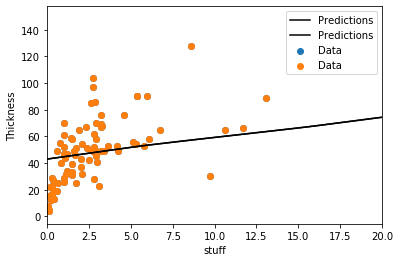

In [29]:

def plot_area(x, y):
    plt.scatter(train_features["AREA"], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('stuff')
    plt.ylabel('Thickness')
    plt.xlim((0,20))
    plt.legend()
    
x = tf.linspace(0.0, 20, 101)
y = dnn_area_model.predict(x)
plot_area(x,y)




plot_area(x, y)

In [30]:
dnn_test_results = {}
dnn_test_results['dnn_area_model'] = dnn_area_model.evaluate(
    test_features["AREA"], test_labels,
    verbose=0)

# Full model (not-quite-working)

In [31]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
dnn_full_model = build_and_compile_model(normalizer)
dnn_full_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_6 (Normalizati (None, 4)                 9         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


In [32]:
%%time
history_full = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 1.83 s, sys: 109 ms, total: 1.94 s
Wall time: 1.68 s


In [33]:
x = tf.linspace(0.0, 250, 251)
y = dnn_full_model.predict(x)

In [34]:
def plot_thickness(x, y):
    plt.scatter(train_features["LON"], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('bbb')
    plt.ylabel('Thickness')
    plt.xlim((0,180))
    plt.legend()
    
x = tf.linspace(0.0, 20, 101)
y = dnn_full_model.predict(x)
plot_elevation(x,y)




plot_thickness(x, y)

NameError: name 'plot_elevation' is not defined

In [ ]:
test_results["dnn_full_model"] = dnn_full_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results

In [ ]:
def plot_loss(history_full):
  plt.plot(history_full.history['loss'], label='loss')
  plt.plot(history_full.history['val_loss'], label='val_loss')
#   plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [THICKNESS]')
  plt.legend()
  plt.grid(True)
plot_loss(history_full)